In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, spearmanr, ttest_ind
from sklearn.metrics import cohen_kappa_score
from scipy.stats import kruskal, mannwhitneyu

In [2]:
data = pd.read_csv("issue-v2-comments_scored.csv", sep=',')

data['created'] = pd.to_datetime(data['created'], format='%a, %d %b %Y %H:%M:%S %z')
data['resolved'] = pd.to_datetime(data['resolved'], format='%a, %d %b %Y %H:%M:%S %z')

data['duration'] = (data['resolved'] - data['created']).dt.total_seconds() / 3600  # in hours

print(data['roberta'].value_counts())
print(data['bert'].value_counts())


roberta
neutral     852
negative    370
positive    201
Name: count, dtype: int64
bert
neutral     882
negative    340
positive    201
Name: count, dtype: int64


## Descriptive Statistics

## RoBERTa

project
camel     186
hadoop    513
hbase     425
impala     79
thrift    220
dtype: int64
roberta  negative  neutral  positive
project                             
camel          40      117        29
hadoop        138      295        80
hbase         110      259        56
impala         14       63         2
thrift         68      118        34
project  roberta 
camel    negative     1563.811431
         neutral      3199.076911
         positive     3514.921954
hadoop   negative     6043.775602
         neutral      4147.663895
         positive     1949.183774
hbase    negative     4369.546194
         neutral      5232.464336
         positive     4677.049747
impala   negative     8725.096806
         neutral      5172.731164
         positive     3872.625556
thrift   negative     7187.593137
         neutral      5813.866841
         positive    12555.765531
Name: duration, dtype: float64


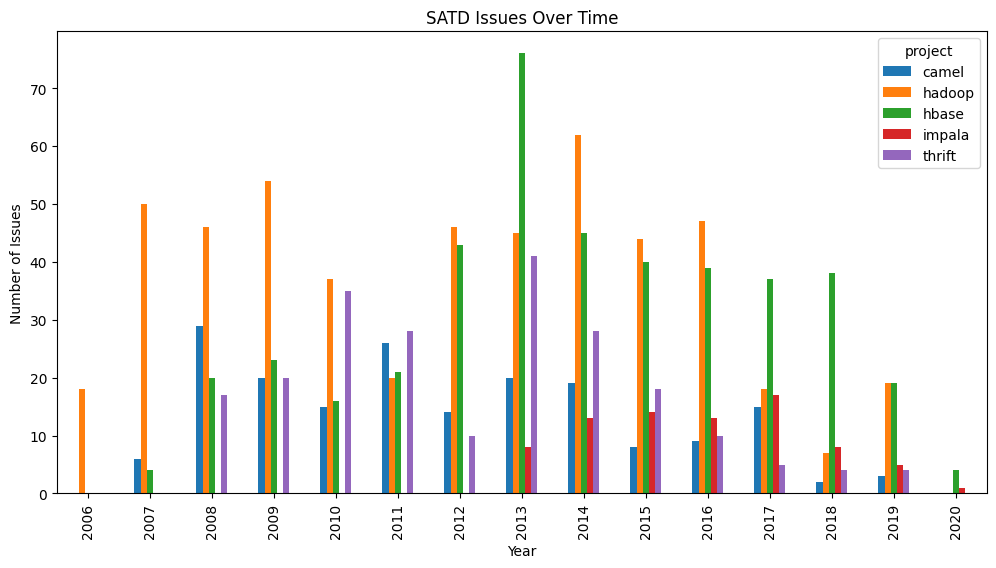

In [4]:
# Count SATD issues by project
satd_counts = data.groupby('project').size()
print(satd_counts)

# Sentiment distribution by project
sentiment_by_project = data.groupby(['project', 'roberta']).size().unstack(fill_value=0)
print(sentiment_by_project)

# Average duration by project and sentiment
avg_duration = data.groupby(['project', 'roberta'])['duration'].mean()
print(avg_duration)

data['created_year'] = data['created'].dt.year
issues_over_time = data.groupby(['project', 'created_year']).size().unstack(fill_value=0)

issues_over_time.T.plot(kind='bar', figsize=(12, 6), title="SATD Issues Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.show()


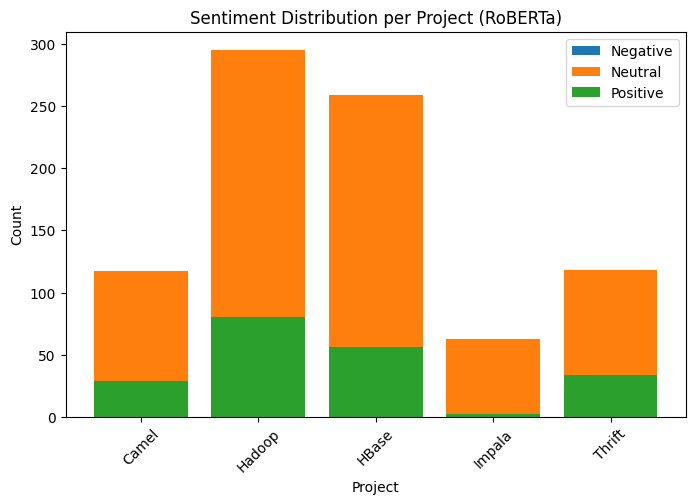

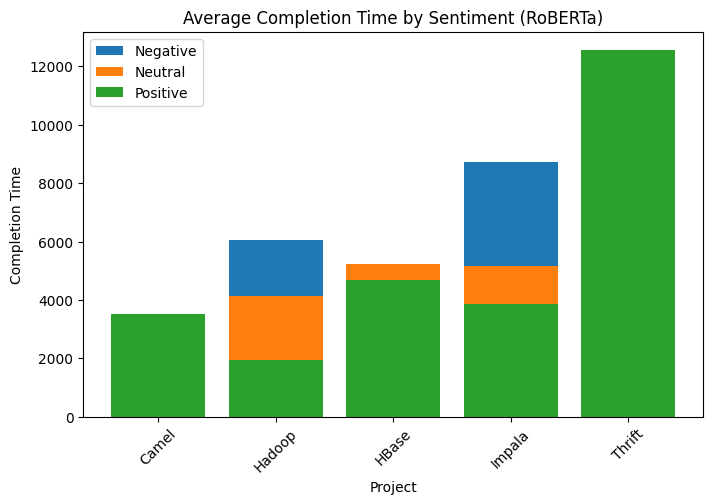

<Figure size 800x500 with 0 Axes>

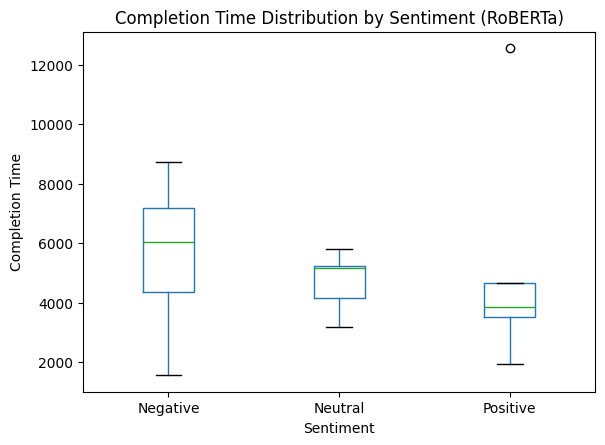

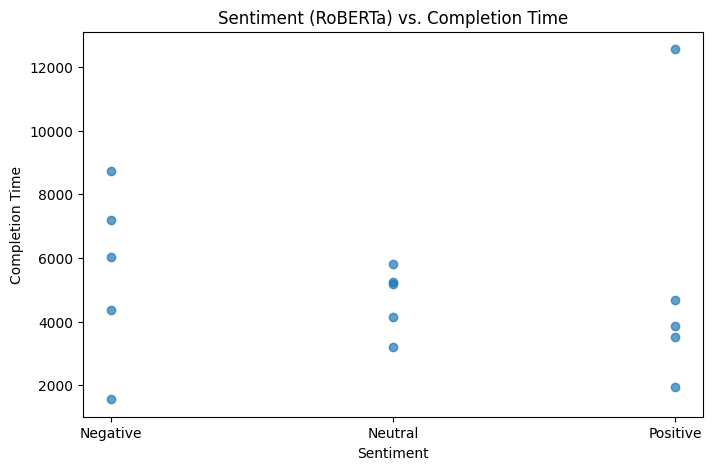

In [5]:
sentiment_distribution = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [40, 138, 110, 14, 68],
    "Neutral": [117, 295, 259, 63, 118],
    "Positive": [29, 80, 56, 2, 34]
})

# Average completion time per sentiment per project (RoBERTa)
completion_time = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [1563.81, 6043.78, 4369.55, 8725.10, 7187.59],
    "Neutral": [3199.08, 4147.66, 5232.46, 5172.73, 5813.80],
    "Positive": [3514.92, 1949.18, 4677.05, 3872.63, 12555.76]  
})

sentiment_distribution_long = sentiment_distribution.melt(id_vars="Project", var_name="Sentiment", value_name="Count")
completion_time_long = completion_time.melt(id_vars="Project", var_name="Sentiment", value_name="Completion Time")

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = sentiment_distribution_long[sentiment_distribution_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Count"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Count")
plt.title("Sentiment Distribution per Project (RoBERTa)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = completion_time_long[completion_time_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Completion Time"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Completion Time")
plt.title("Average Completion Time by Sentiment (RoBERTa)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
completion_time_long.boxplot(by="Sentiment", column="Completion Time", grid=False)
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Completion Time Distribution by Sentiment (RoBERTa)")
plt.suptitle("")
plt.show()


plt.figure(figsize=(8, 5))
sentiment_mapping = {"Negative": 1, "Neutral": 2, "Positive": 3}
completion_time_long["Sentiment Numeric"] = completion_time_long["Sentiment"].map(sentiment_mapping)
plt.scatter(completion_time_long["Sentiment Numeric"], completion_time_long["Completion Time"], alpha=0.7)
plt.xticks([1, 2, 3], ["Negative", "Neutral", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Sentiment (RoBERTa) vs. Completion Time")
plt.show()


In [6]:
positive_durations = data[data["roberta"] == "positive"]["duration"]
neutral_durations = data[data["roberta"] == "neutral"]["duration"]
negative_durations = data[data["roberta"] == "negative"]["duration"]

# Kruskal-Wallis
h_stat, p_value = kruskal(positive_durations, neutral_durations, negative_durations)

print("\n=== Kruskal-Wallis H Test ===")
print(f"Test Statistic: {h_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Significant difference found between sentiment groups. Proceeding with pairwise tests.\n")
else:
    print("No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.")
    exit() 

# Pairwise Mann-Whitney U Tests
print("\n=== Pairwise Mann-Whitney U Tests ===")
comparisons = [("negative", "positive"), ("negative", "neutral")]
for group1, group2 in comparisons:
    group1_durations = data[data["roberta"] == group1]["duration"]
    group2_durations = data[data["roberta"] == group2]["duration"]
    
    u_stat, p_value = mannwhitneyu(group1_durations, group2_durations, alternative='greater')
    
    print(f"Comparing {group1} vs {group2}:")
    print(f"  - Mann-Whitney U Statistic: {u_stat}")
    print(f"  - P-value: {p_value}")

    if p_value < 0.05:
        print(f"  - **Reject H₀**: {group1} sentiment issues take significantly longer to resolve than {group2} issues.\n")
    else:
        print(f"  - **Fail to reject H₀**: No significant difference between {group1} and {group2} in resolution time.\n")



=== Kruskal-Wallis H Test ===
Test Statistic: 5.087716378303762, P-value: 0.07856270453614723
No significant difference between sentiment groups. Negative sentiment does NOT take longer on average.

=== Pairwise Mann-Whitney U Tests ===
Comparing negative vs positive:
  - Mann-Whitney U Statistic: 41222.5
  - P-value: 0.01601056277479339
  - **Reject H₀**: negative sentiment issues take significantly longer to resolve than positive issues.

Comparing negative vs neutral:
  - Mann-Whitney U Statistic: 162819.0
  - P-value: 0.17953459948394213
  - **Fail to reject H₀**: No significant difference between negative and neutral in resolution time.


## BERT

project
camel     186
hadoop    513
hbase     425
impala     79
thrift    220
dtype: int64
bert     negative  neutral  positive
project                             
camel          41      114        31
hadoop        132      302        79
hbase         102      272        51
impala         13       61         5
thrift         52      133        35
project  bert    
camel    negative     1732.213780
         neutral      3072.921762
         positive     3788.495054
hadoop   negative     5834.046141
         neutral      4432.884629
         positive     1325.459940
hbase    negative     4379.944946
         neutral      5680.445056
         positive     2077.209619
impala   negative     6932.174188
         neutral      5773.886393
         positive     2690.667056
thrift   negative     7411.717516
         neutral      6084.141589
         positive    11631.100183
Name: duration, dtype: float64


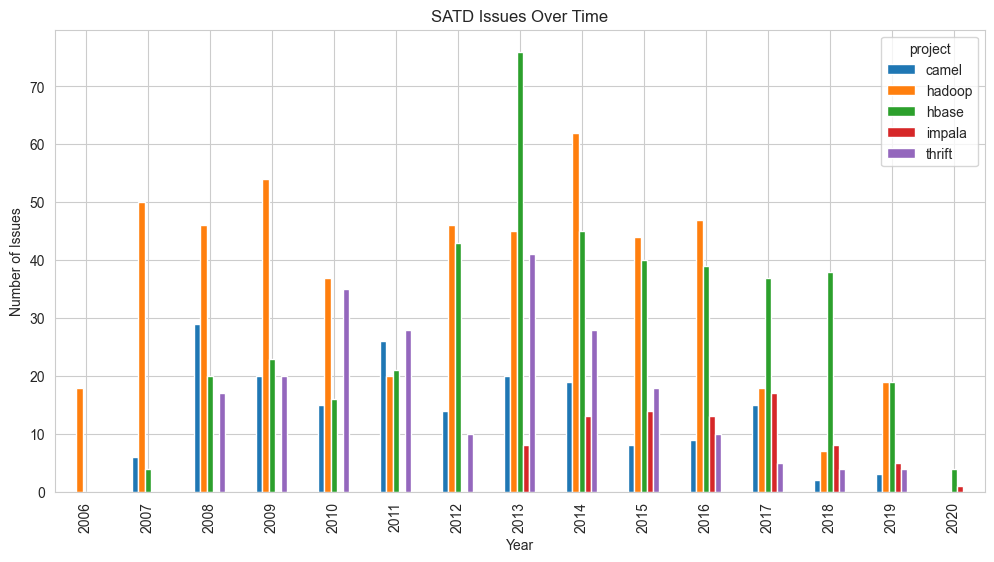

In [3]:
# Count SATD issues by project
satd_counts = data.groupby('project').size()
print(satd_counts)

# Sentiment distribution by project
sentiment_by_project = data.groupby(['project', 'bert']).size().unstack(fill_value=0)
print(sentiment_by_project)

# Average duration by project and sentiment
avg_duration = data.groupby(['project', 'bert'])['duration'].mean()
print(avg_duration)

data['created_year'] = data['created'].dt.year
issues_over_time = data.groupby(['project', 'created_year']).size().unstack(fill_value=0)

issues_over_time.T.plot(kind='bar', figsize=(12, 6), title="SATD Issues Over Time")
plt.ylabel("Number of Issues")
plt.xlabel("Year")
plt.show()


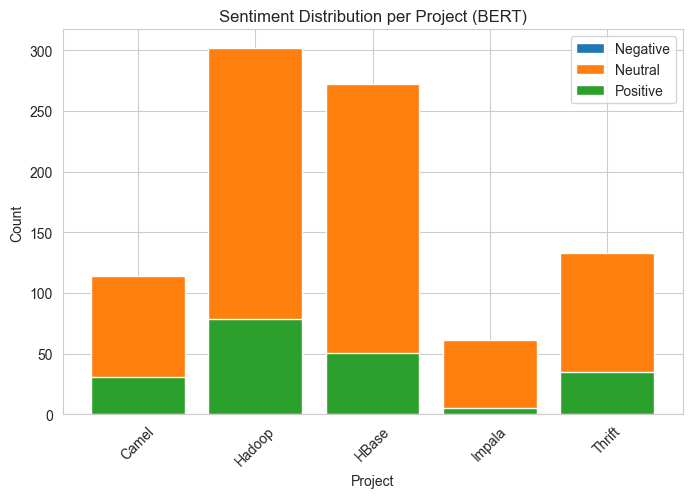

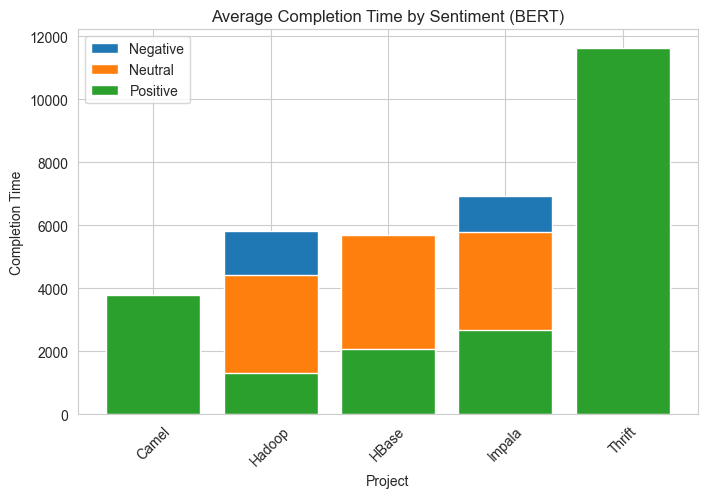

<Figure size 800x500 with 0 Axes>

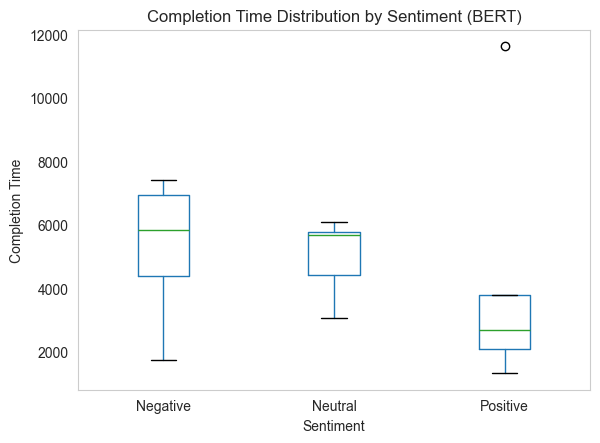

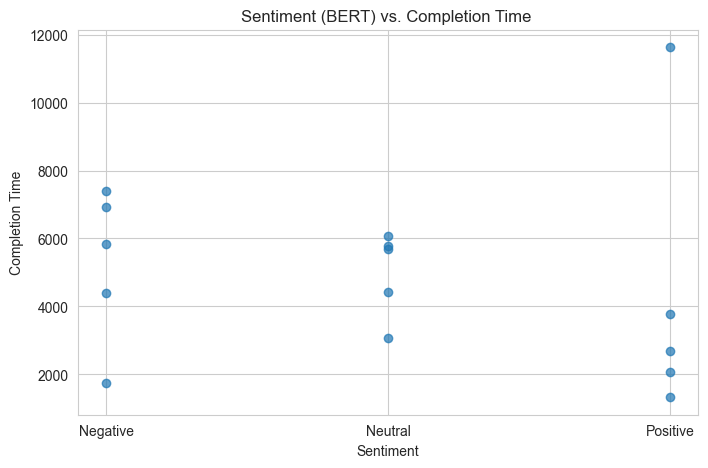

In [4]:
sentiment_distribution = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [41, 132, 102, 13, 52],
    "Neutral": [114, 302, 272, 61, 133],
    "Positive": [31, 79, 51, 5, 35]
})

# Average completion time per sentiment per project (BERT)
completion_time = pd.DataFrame({
    "Project": ["Camel", "Hadoop", "HBase", "Impala", "Thrift"],
    "Negative": [1732.21, 5834.05, 4379.94, 6932.17, 7411.72],
    "Neutral": [3072.92, 4432.88, 5680.45, 5773.88, 6084.14],
    "Positive": [3788.49, 1325.46, 2077.21, 2690.67, 11631.1]  
})

sentiment_distribution_long = sentiment_distribution.melt(id_vars="Project", var_name="Sentiment", value_name="Count")
completion_time_long = completion_time.melt(id_vars="Project", var_name="Sentiment", value_name="Completion Time")

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = sentiment_distribution_long[sentiment_distribution_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Count"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Count")
plt.title("Sentiment Distribution per Project (BERT)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
for sentiment in ["Negative", "Neutral", "Positive"]:
    subset = completion_time_long[completion_time_long["Sentiment"] == sentiment]
    plt.bar(subset["Project"], subset["Completion Time"], label=sentiment)

plt.xlabel("Project")
plt.ylabel("Completion Time")
plt.title("Average Completion Time by Sentiment (BERT)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
completion_time_long.boxplot(by="Sentiment", column="Completion Time", grid=False)
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Completion Time Distribution by Sentiment (BERT)")
plt.suptitle("")
plt.show()


plt.figure(figsize=(8, 5))
sentiment_mapping = {"Negative": 1, "Neutral": 2, "Positive": 3}
completion_time_long["Sentiment Numeric"] = completion_time_long["Sentiment"].map(sentiment_mapping)
plt.scatter(completion_time_long["Sentiment Numeric"], completion_time_long["Completion Time"], alpha=0.7)
plt.xticks([1, 2, 3], ["Negative", "Neutral", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Completion Time")
plt.title("Sentiment (BERT) vs. Completion Time ")
plt.show()
